# Deep Learning - Assigment 3 <br>
Submmited By: Ron Faygler, Tal Ben Shimon, Shay Sitri



<p> 0.   Data Analysis </p>
<p> 1.   Q1 - Charcter Level</p>
<p> 2.   Q2 - World Level</p>



In [1]:
!pip install -q transformers
!pip install -q lightning
!pip install -q gensim
!pip install -q nltk
!pip install -q pytorch-lightning

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-depot-product-search-relevance

 94% 65.0M/69.4M [00:00<00:00, 168MB/s] 
100% 69.4M/69.4M [00:00<00:00, 158MB/s]


In [ ]:
!unzip -q home-depot-product-search-relevance.zip -d home-depot-product-search-relevance


# Imports

In [2]:
from typing import Any
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import gzip
import zipfile
import gensim
import logging
import numpy as np
import pandas as pd
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from pprint import pprint
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from gensim import corpora
from pytorch_lightning import Trainer
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import Trainer, callbacks
import neptune
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, f1_score, confusion_matrix, log_loss
import seaborn as sns
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import lightning as L
from torchmetrics import Accuracy
import pytorch_lightning as pl
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import operator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from gensim import models
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pytorch_lightning import Trainer, callbacks
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/ronfay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ronfay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ronfay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
stop_words = set(stopwords.words('english'))

# Helpers

## plot_histogram

In [6]:
def plot_histogram(data, x, title, endAt = None, start = None, grams=None) :
  """
  This function plot histogram.
  data: counter (key, value - number of appearnces)
  x: string, x axis name
  title: title of the plot
  endAt: take only the *endAt* first rows
  start: take from the firt *start* rows
  grmas: the data contain grams-keys and therefore should be transformed
  """

  sorted_dict = dict(sorted(data.items(), key=operator.itemgetter(1), reverse=True))
  # Convert the defaultdict to a DataFrame for Seaborn
  if grams:
    new_dict = {}
    for key in sorted_dict:
      new_key = ' '.join(list(key))
      new_dict[new_key] = sorted_dict[key]
    # Convert the defaultdict to a DataFrame for Seaborn
    data = {x : list(new_dict.keys()), 'Count': list(new_dict.values())}
  else:
      data = {x: list(sorted_dict.keys()), 'Count': list(sorted_dict.values())}
  df = pd.DataFrame(data)
  # Create a bar plot using Seaborn
  sns.set(style="whitegrid")
  plt.figure(figsize=(12, 6))
  if start:
    df = df[start:]
  if endAt:
    df = df[:endAt]
  bar_plot = sns.barplot(x=x , y='Count', data=df, palette='viridis')
  plt.title(title)
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.show()
  plt.show()

## create_dict_for_corpus

In [30]:
def create_dict_for_corpus(train_df, test_df):
    """
    This function get test & train df and return it as coropra form.
    The coropora consist from search term & product description tokens.
    """
    char_dict = {}

    # Iterate over 'product_descriptions' in merged_df
    for des in train_df['product_description']:
        for word in des.lower():  # no .split()
            for char in word:
                if char not in char_dict:
                    char_dict[char] = 1
                else:
                    char_dict[char] += 1

    # Iterate over 'search_term' in merged_df
    for term in train_df['search_term']:
        for word in term.lower():
            for char in word:
                if char not in char_dict:
                    char_dict[char] = 1
                else:
                    char_dict[char] += 1

    # Iterate over 'product_descriptions' in test_merged_df
    for des in test_df['product_description']:
        for word in des.lower():  # no .split()
            for char in word:
                if char not in char_dict:
                    char_dict[char] = 1
                else:
                    char_dict[char] += 1

    # Iterate over 'search_term' in test_merged_df
    for term in test_df['search_term']:
        for word in term.lower():
            for char in word:
                if char not in char_dict:
                    char_dict[char] = 1
                else:
                    char_dict[char] += 1

    tokens = [[char for char in word] for word in char_dict.keys()]
    dictionary = corpora.Dictionary(tokens)
    dictionary.save('deerwester.dict')  # store the dictionary, for future reference

    return dictionary, char_dict


# Q0 - Data Analysis

Read the data

In [29]:
all_train_df = pd.read_csv("./home-depot-product-search-relevance/train.csv.zip", encoding="latin-1")

In [30]:
all_train_df

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67
...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00


In [31]:
all_test_df = pd.read_csv("./home-depot-product-search-relevance/test.csv.zip", encoding="latin-1")

In [32]:
all_test_df

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668
...,...,...,...,...
166688,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet
166689,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion
166690,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb
166691,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets


Relevance - is our predicted variable

In [9]:
all_train_df['relevance'].value_counts()

relevance
3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.75       11
2.25       11
1.75        9
1.50        5
1.25        4
Name: count, dtype: int64

In [33]:
product_descriptions_df = pd.read_csv("./home-depot-product-search-relevance/product_descriptions.csv.zip")

In [34]:
# Merge the product_descriptions_df with the training and testing set df using product_uid
train_merged_df = pd.merge(all_train_df, product_descriptions_df, on='product_uid', how='left')
test_merged_df = pd.merge(all_test_df, product_descriptions_df, on='product_uid', how='left')

In [35]:
solution = pd.read_csv("solution.csv")

In [36]:
test_merged_df =  pd.merge(test_merged_df, solution, on='id', how='left')

In [37]:
train_merged_df

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...
...,...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00,"Atlantic, Inc. 94835722 Uniquely designed for ..."
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00,Philips Energy Advantage lamps use less energy...
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33,The Schlage Camelot In-Active Aged Bronze Hand...
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00,The Rose Garden is inspired by the popular ear...


## Product Decription

Create mage df contains all test & train for data statistics and analysis

In [ ]:
merged_product_description = pd.concat([train_merged_df, test_merged_df], axis=0)

In [ ]:
merged_product_description

,id,product_uid,product_title,search_term,relevance,product_description,Usage
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",NaN
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",NaN
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,NaN
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,NaN
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,NaN
...,...,...,...,...,...,...,...
166688,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet,-1.00,Create a neat yet stylish storage space for or...,Ignored
166689,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion,-1.00,Our Bullnose Adirondack Chair Cushions fit Adi...,Ignored
166690,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb,-1.00,Joist hangers are designed to provide support ...,Ignored
166691,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets,-1.00,These socket cap screws are ideal for applicat...,Ignored


In [ ]:
merged_product_description = merged_product_description[[	'product_uid',	'product_description',		'product_title'	]]

In [ ]:
merged_product_description_descriptions = merged_product_description['product_description'].values

## 1. Charcter Level

### a. With stopwords

In [ ]:
product_descriptions = []
for x in merged_product_description_descriptions:
  product_descriptions.append([word for word in x.lower().split() if word != " "])

In [ ]:
merged_product_description_descriptions_set_c_level = []
merged_product_description_descriptions_set_c_level.extend(str(product_descriptions))

Number of schars include **stop words**

In [ ]:
len(merged_product_description_descriptions_set_c_level)

311166710

In [ ]:
charcters = Counter(merged_product_description_descriptions_set_c_level)

#### Charcter Count plots

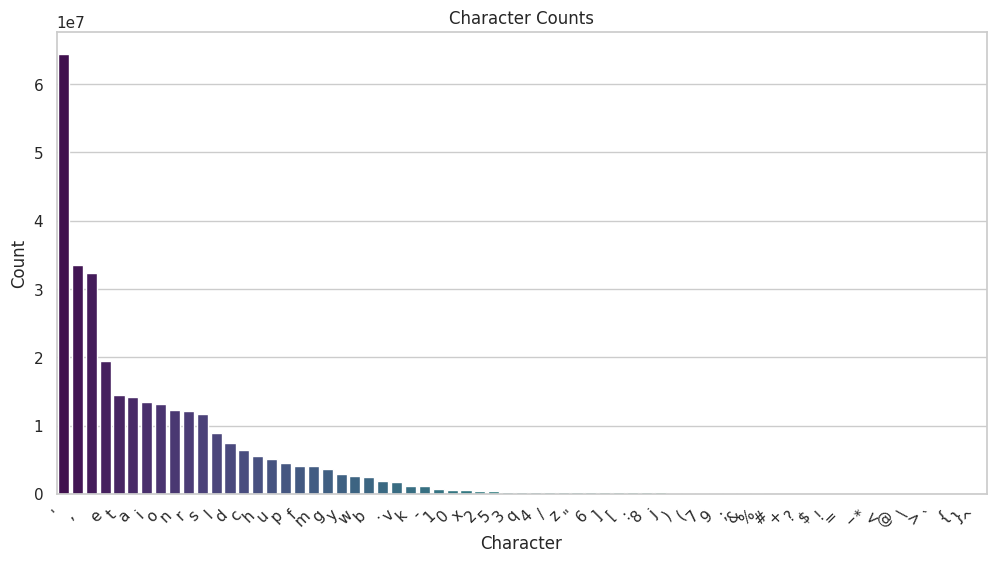

In [ ]:
plot_histogram(charcters, 'Character', 'Character Counts')

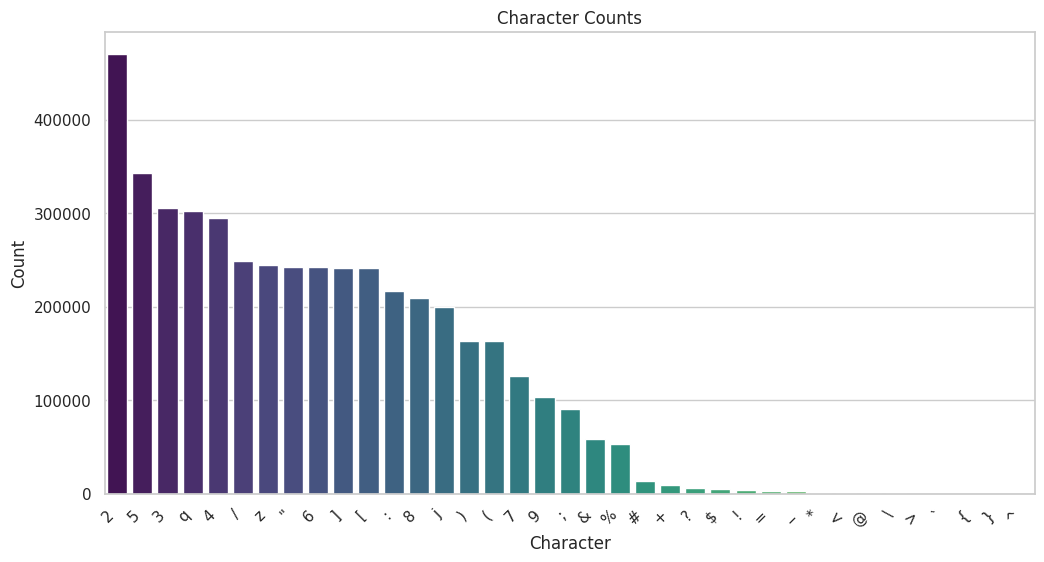

In [ ]:
plot_histogram(charcters, 'Character', 'Character Counts', start = 30)

### b. Without stopwords

In [ ]:
product_descriptions_no_stopwords = []
for x in merged_product_description_descriptions:
  product_descriptions_no_stopwords.append([word for word in x.lower().split() if word not in stop_words and word != " "])

In [ ]:
merged_product_description_descriptions_set_c_level = []
merged_product_description_descriptions_set_c_level.extend(str(product_descriptions_no_stopwords))

Number of chars exclude **stop words**

In [ ]:
len(merged_product_description_descriptions_set_c_level)

245382685

In [ ]:
charcters = Counter(merged_product_description_descriptions_set_c_level)

#### Charcter Count plot

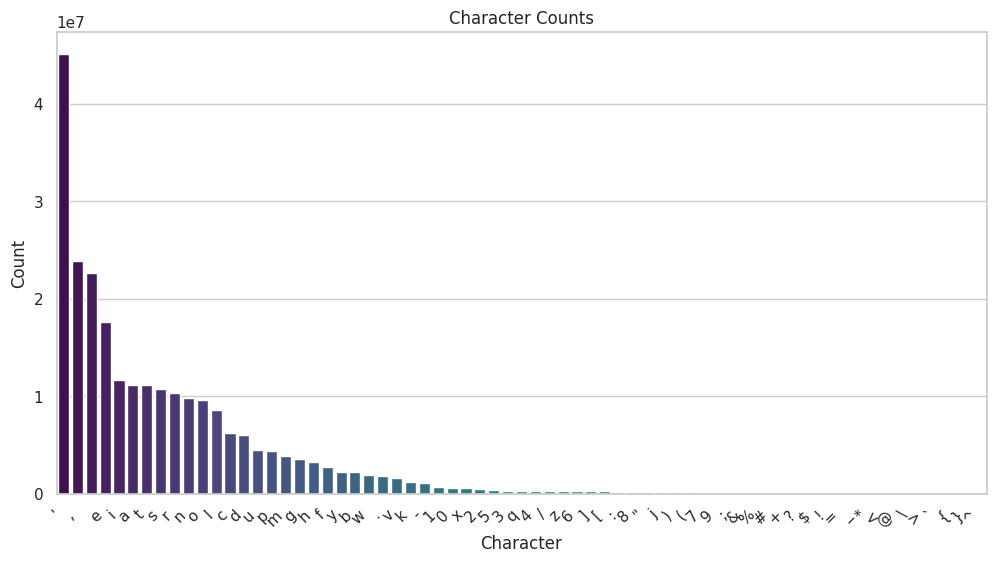

In [ ]:
plot_histogram(charcters, 'Character', 'Character Counts')

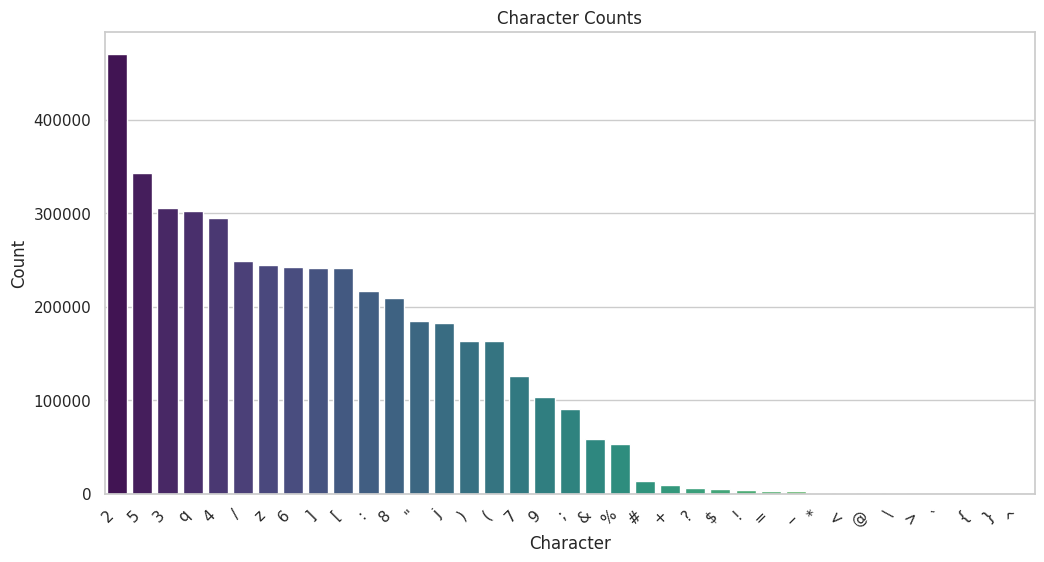

In [ ]:
plot_histogram(charcters, 'Character', 'Character Counts', start = 30)

## 2. Word Level

In this part, we spllited word according " ", <br>
We want to relate conjunctions as 1 word. <br>
For example, '4-in-1' is 1 word and not 3.

The pre-process remove stopwords, and apply lemma.
We will check how the lemmatization affect on the word distribution.

In [ ]:
lem = nltk.WordNetLemmatizer()

dict_words_2ngrams = Counter()
dict_words_3ngrams = Counter()
dict_words_4ngrams = Counter()

dict_words = Counter()

dict_words_2vec_stop = []

for product_description in merged_product_description_descriptions:
  product_description = product_description.lower()
  product_description = product_description.split()
  product_descriptions_no_stopwords  = [word for word in product_description if word not in stop_words and word != " "]
  dict_words_2vec_stop.append(dict_words_2vec_stop)
  dict_words_2ngrams.update(ngrams(product_descriptions_no_stopwords,2))
  dict_words_3ngrams.update(ngrams(product_descriptions_no_stopwords,3))
  dict_words_4ngrams.update(ngrams(product_descriptions_no_stopwords,4))

  dict_words.update(product_descriptions_no_stopwords)


### a. Without stopwords

#### 1. Total word count plot

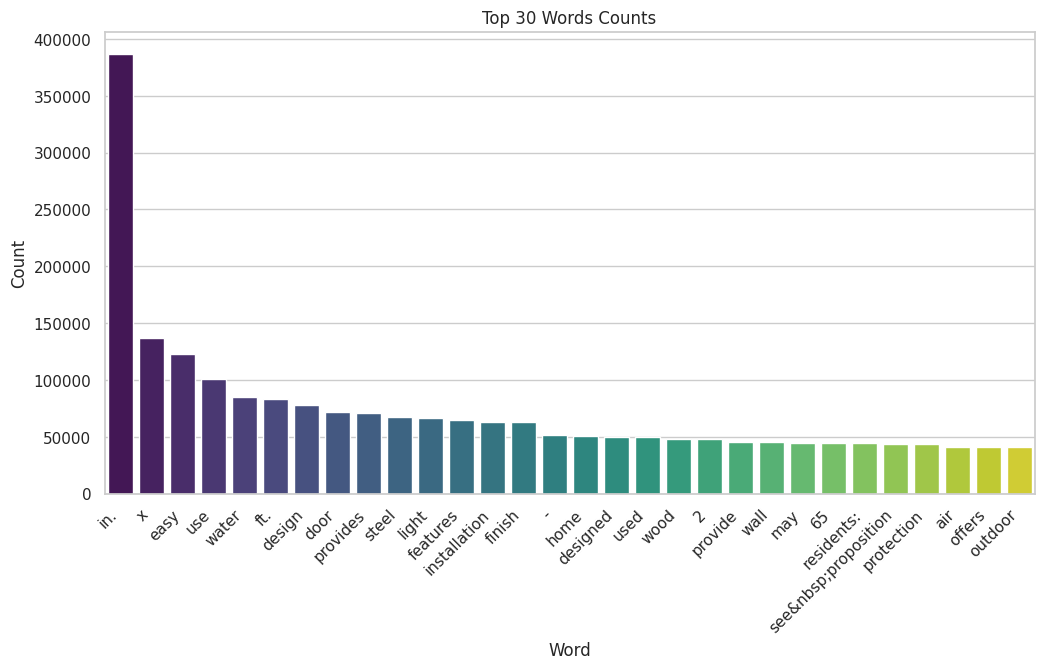

In [ ]:
plot_histogram(dict_words, 'Word', 'Top 30 Words Counts', endAt=30)

#### 2. 2-grams count plot

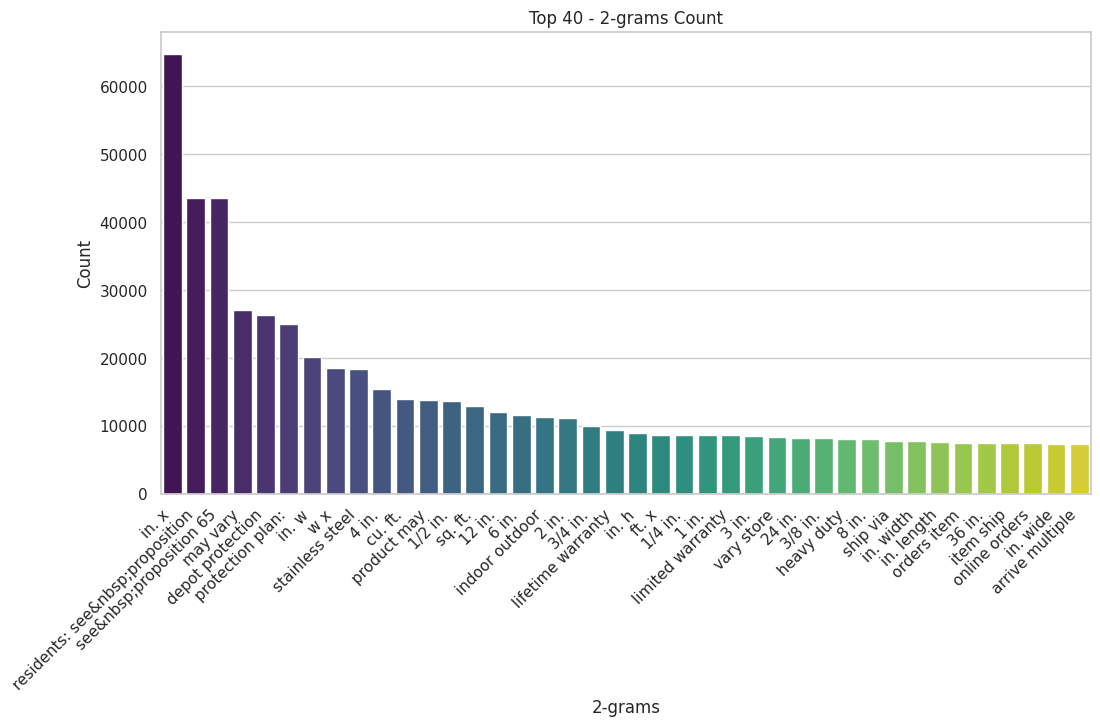

In [ ]:
plot_histogram(dict_words_2ngrams, '2-grams', 'Top 40 - 2-grams Count', endAt=40, grams=True)

#### 3. 3-grams count plot

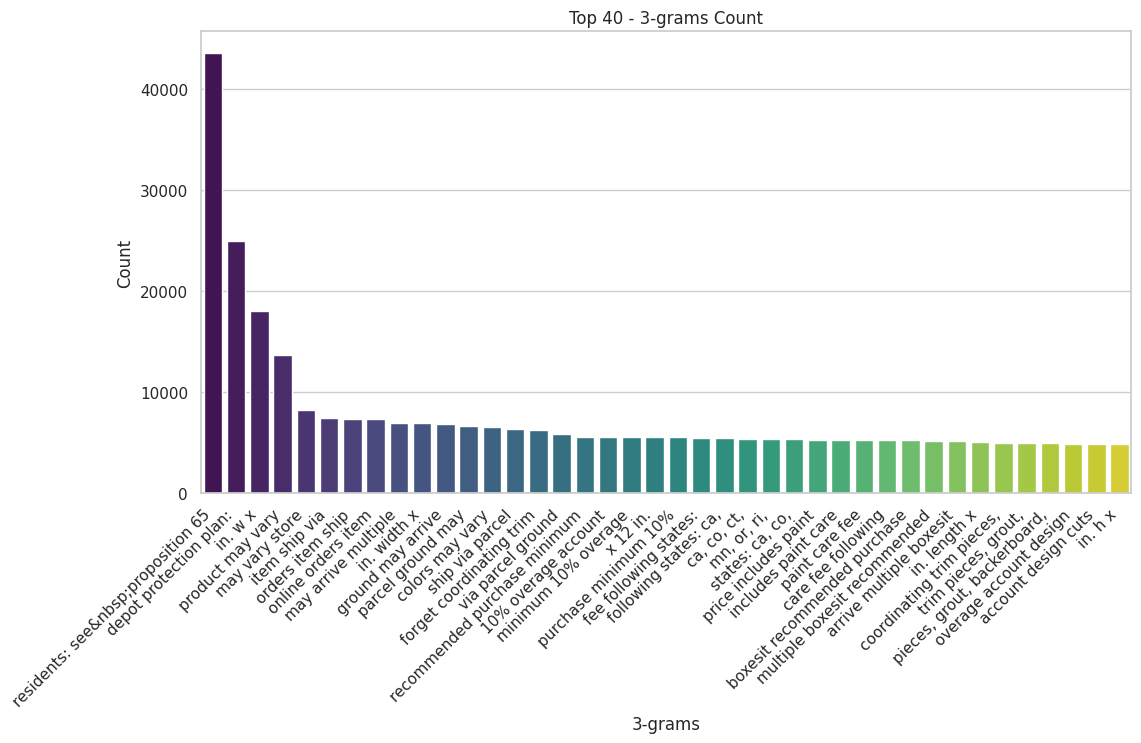

In [ ]:
plot_histogram(dict_words_3ngrams, '3-grams', 'Top 40 - 3-grams Count', endAt=40, grams=True)

#### 4. 4-grams cound plot

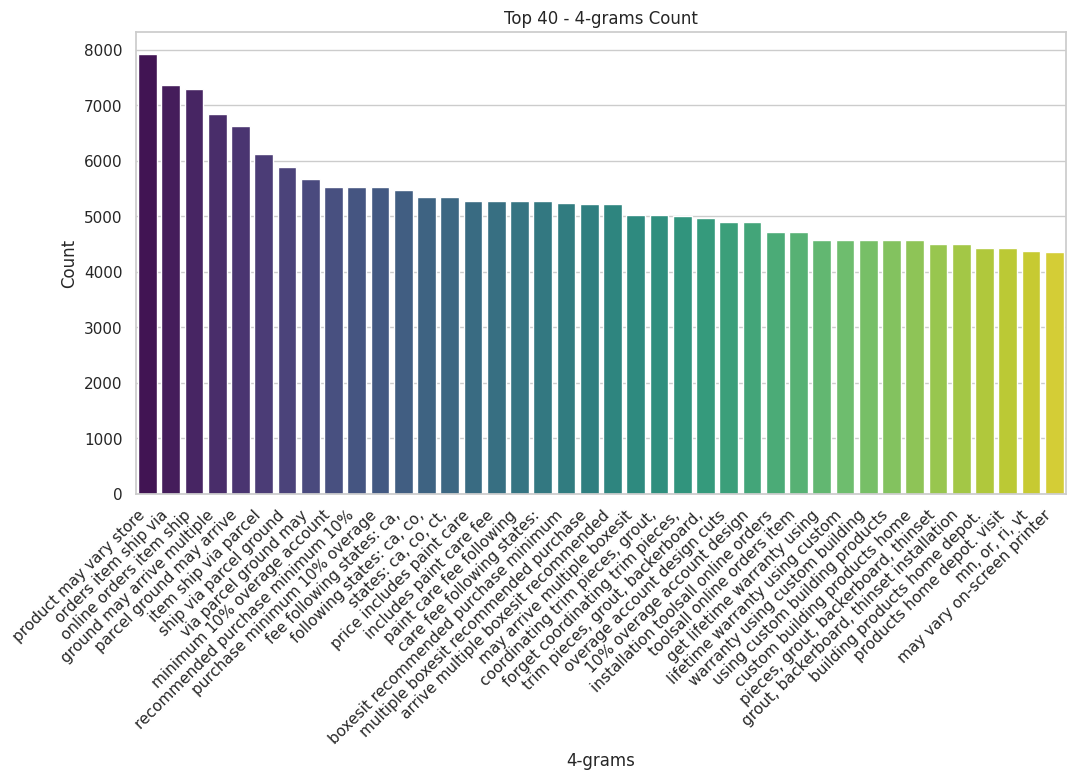

In [ ]:
plot_histogram(dict_words_4ngrams, '4-grams', 'Top 40 - 4-grams Count', endAt=40, grams=True)

### b. Without stopwords & with lemmatization

In [ ]:
lem = nltk.WordNetLemmatizer()

dict_words_2ngrams_lemma = Counter()
dict_words_3ngrams_lemma = Counter()
dict_words_4ngrams_lemma = Counter()

dict_words_lemma = Counter()

dict_words_2vec = []

for product_description in merged_product_description_descriptions:
  product_description = product_description.lower()
  product_description = product_description.split()
  product_descriptions_no_stopwords_lemma  = [lem.lemmatize(word) for word in product_description if word not in stop_words and word != " "]
  dict_words_2vec.append(product_descriptions_no_stopwords_lemma)
  dict_words_2ngrams_lemma.update(ngrams(product_descriptions_no_stopwords_lemma,2))
  dict_words_3ngrams_lemma.update(ngrams(product_descriptions_no_stopwords_lemma,3))
  dict_words_4ngrams_lemma.update(ngrams(product_descriptions_no_stopwords_lemma,4))

  dict_words_lemma.update(product_descriptions_no_stopwords_lemma)

#### 1. Total word count plot

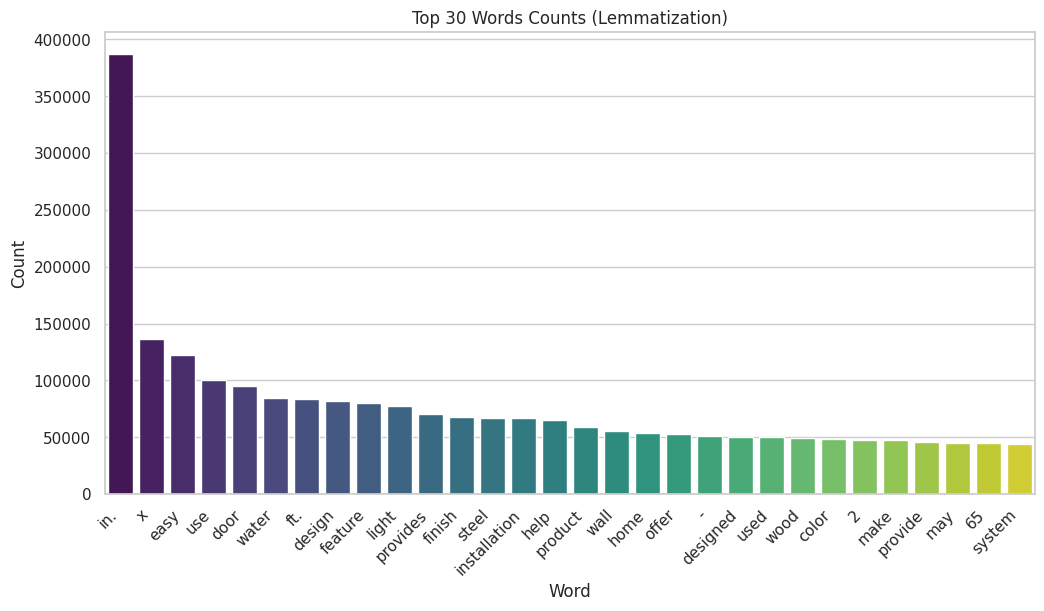

In [ ]:
plot_histogram(dict_words_lemma, 'Word', 'Top 30 Words Counts (Lemmatization)', endAt=30)

#### 2. 2-grams count plot

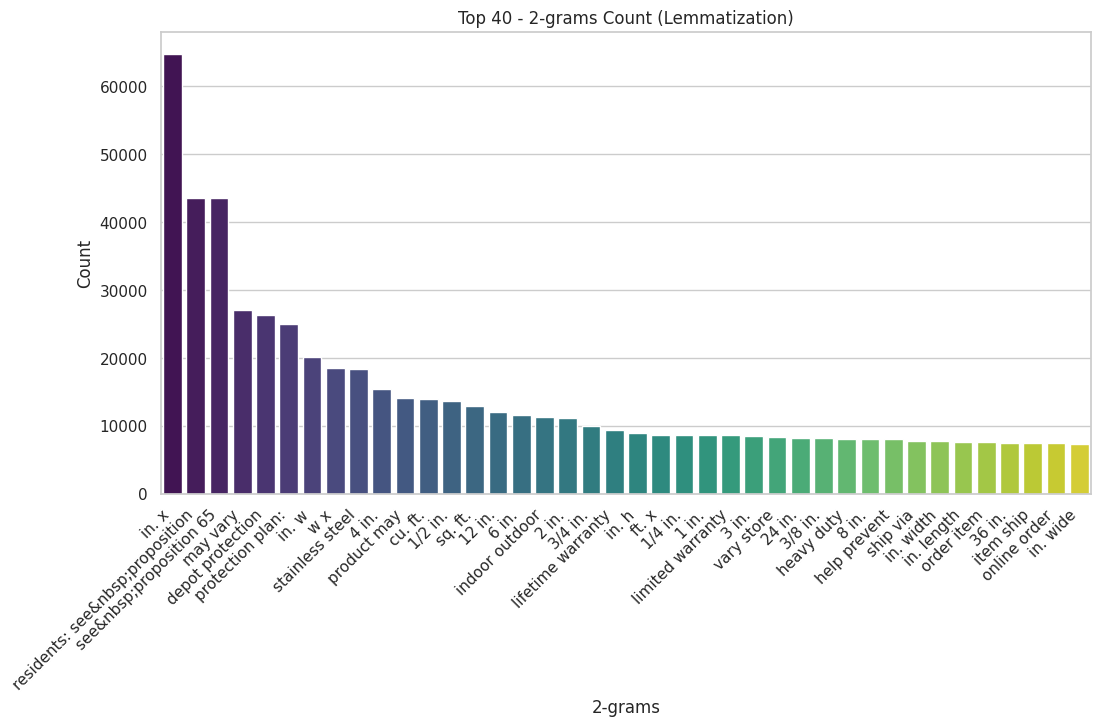

In [ ]:
plot_histogram(dict_words_2ngrams_lemma, '2-grams', 'Top 40 - 2-grams Count (Lemmatization)', endAt=40, grams=True)

#### 3. 3-grams count plot

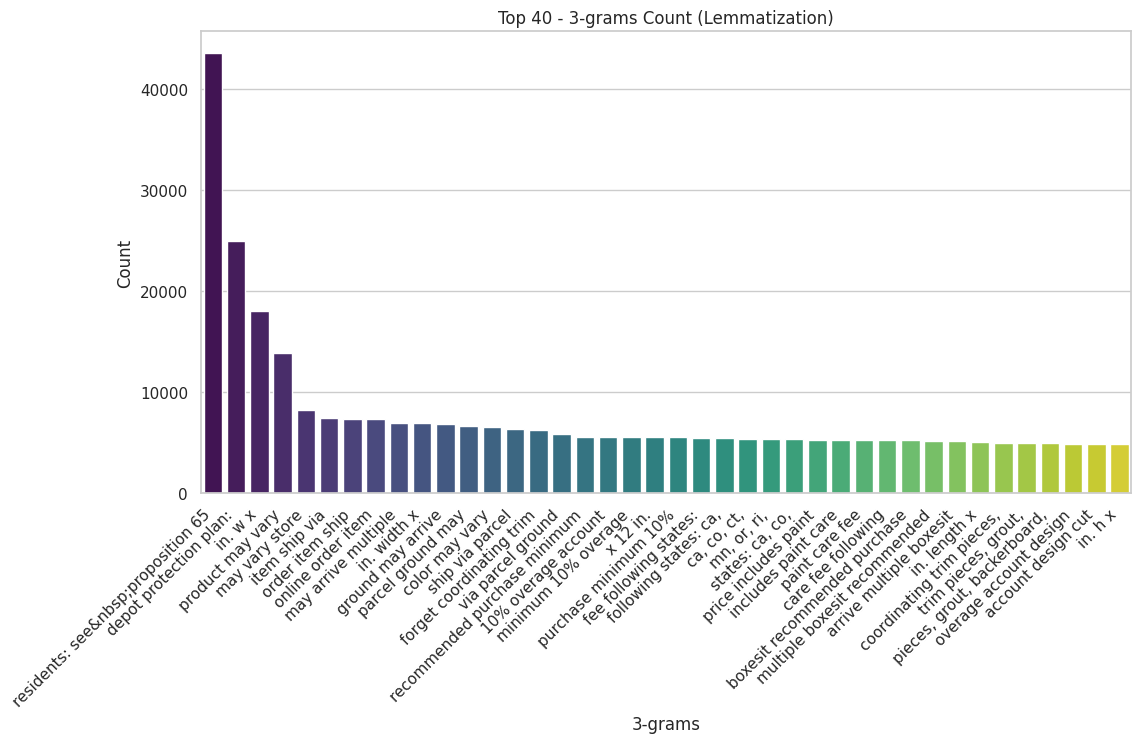

In [ ]:
plot_histogram(dict_words_3ngrams_lemma, '3-grams', 'Top 40 - 3-grams Count (Lemmatization)', endAt=40, grams=True)

#### 4. 4-grams count plot

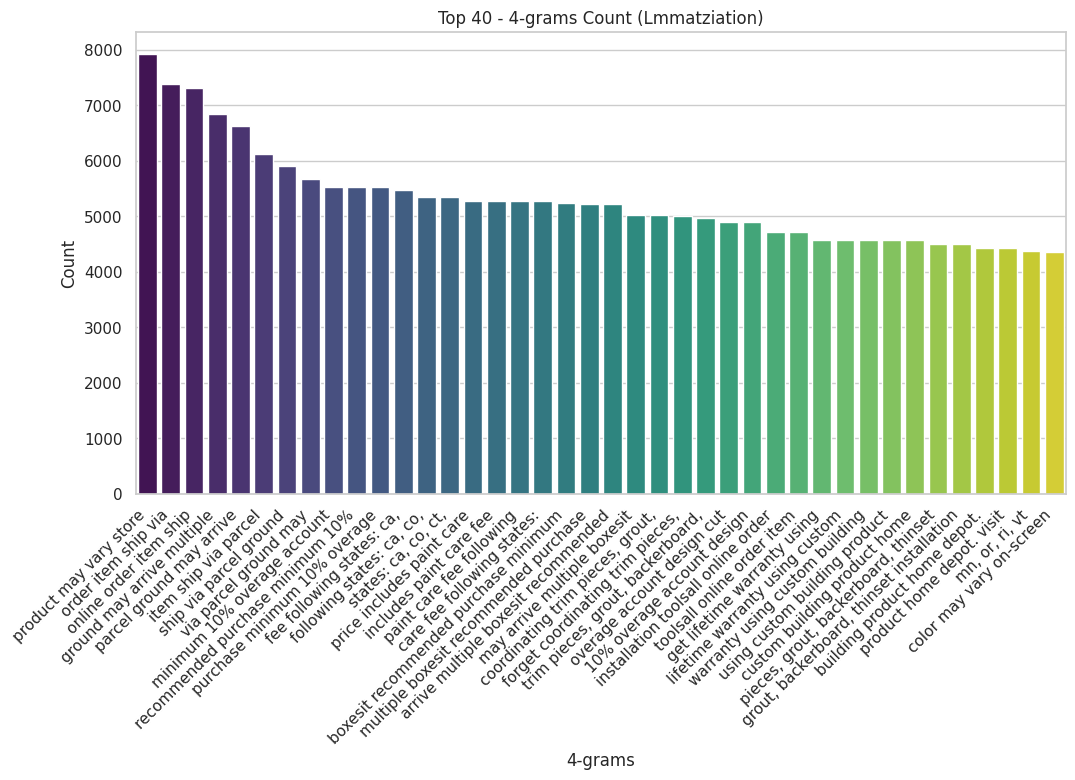

In [ ]:
plot_histogram(dict_words_4ngrams_lemma, '4-grams', 'Top 40 - 4-grams Count (Lmmatziation)', endAt=40, grams=True)

### c. Embedding Analysis
With word2vec

In [ ]:
model_with_lemma = gensim.models.Word2Vec(
    dict_words_2vec,
    vector_size=50,
    window=5,
    min_count=1,
    workers=10)

In [ ]:
model_with_lemma.train(dict_words_2vec, total_examples=len(dict_words_2vec), epochs=10)

(220623739, 226038070)

In [ ]:
keys = list(dict_words_lemma.keys())[:15]

NameError: name 'dict_words_lemma' is not defined

In [ ]:
vectors = [model.wv.get_vector(w) for w in keys]

In [ ]:
pca = PCA(n_components=3)
pcas = pca.fit_transform(vectors)

In [ ]:
plt.figure(figsize=(25,8))
ax = plt.axes(projection='3d')
ax.scatter(xs=pcas[:,0],ys=pcas[:,1],zs=pcas[:,2],cmap='RdBu',c=range(pcas.shape[0]))
for i,w in enumerate(keys):
    ax.text(pcas[i,0],pcas[i,1],pcas[i,2],w)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f241481d000> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f241481c280> (for post_execute):


KeyboardInterrupt: 

In [ ]:
model = gensim.models.Word2Vec(
    dict_words_2vec_stop,
    vector_size=50,
    window=5,
    min_count=1,
    workers=10)

In [ ]:
model.train(dict_words_2vec_stop, total_examples=len(dict_words_2vec), epochs=10)

In [ ]:
keys = list(dict_words.keys())[:15]

In [ ]:
vectors = [model.wv.get_vector(w) for w in keys]

In [ ]:
pca = PCA(n_components=3)
pcas = pca.fit_transform(vectors)

In [ ]:
plt.figure(figsize=(25,8))
ax = plt.axes(projection='3d')
ax.scatter(xs=pcas[:,0],ys=pcas[:,1],zs=pcas[:,2],cmap='RdBu',c=range(pcas.shape[0]))
for i,w in enumerate(keys):
    ax.text(pcas[i,0],pcas[i,1],pcas[i,2],w)

## Search Term

In [ ]:
search_terms = merged_product_description['search_term'].values

## 1. Charcter Level

### a. With stopwords

In [ ]:
search_terms_list = []
for x in search_terms:
  search_terms_list.append([word for word in x.lower().split() if word != " "])

In [ ]:
search_terms_c_level = []
search_terms_c_level.extend(str(search_terms))

Number of schars include **stop words**

In [ ]:
len(merged_product_description_descriptions_set_c_level)

In [ ]:
charcters = Counter(merged_product_description_descriptions_set_c_level)

#### Charcter Count plots

In [ ]:
plot_histogram(charcters, 'Character', 'Character Counts')

### b. Without stopwords

In [ ]:
search_term_no_stopwords = []
for x in search_terms:
  search_term_no_stopwords.append([word for word in x.lower().split() if word not in stop_words and word != " "])

In [ ]:
search_terms_c_level = []
search_terms_c_level.extend(str(search_term_no_stopwords))

Number of chars exclude **stop words**

In [ ]:
charcters = Counter(search_term_no_stopwords)

#### Charcter Count plot

In [ ]:
plot_histogram(charcters, 'Character', 'Character Counts')

## 2. Word Level

### a. Without stopwords

In [ ]:
lem = nltk.WordNetLemmatizer()

dict_words_2ngrams = Counter()
dict_words_3ngrams = Counter()
dict_words_4ngrams = Counter()

dict_words = Counter()

dict_words_2vec_stop = []

for term in search_terms:
  term = term.lower()
  term = term.split()
  search_term_no_stopwords  = [word for word in term if word not in stop_words and word != " "]
  dict_words_2vec_stop.append(dict_words_2vec_stop)
  dict_words_2ngrams.update(ngrams(search_term_no_stopwords,2))
  dict_words_3ngrams.update(ngrams(search_term_no_stopwords,3))
  dict_words_4ngrams.update(ngrams(search_term_no_stopwords,4))

  dict_words.update(search_term_no_stopwords)


#### 1. Total word count plot

In [ ]:
plot_histogram(dict_words, 'Word', 'Top 30 Words Counts', endAt=30)

#### 2. 2-grams count plot

In [ ]:
plot_histogram(dict_words_2ngrams, '2-grams', 'Top 40 - 2-grams Count', endAt=40, grams=True)

#### 3. 3-grams count plot

In [ ]:
plot_histogram(dict_words_3ngrams, '3-grams', 'Top 40 - 3-grams Count', endAt=40, grams=True)

#### 4. 4-grams count plot

In [ ]:
plot_histogram(dict_words_4ngrams, '4-grams', 'Top 40 - 4-grams Count', endAt=40, grams=True)

### b. Without stopwords & with lemmatization

In [ ]:
lem = nltk.WordNetLemmatizer()

dict_words_2ngrams_lemma = Counter()
dict_words_3ngrams_lemma = Counter()
dict_words_4ngrams_lemma = Counter()

dict_words_lemma = Counter()

dict_words_2vec = []

for term in search_terms:
  term = term.split()
  search_term_no_stopwords  = [lem.lemmatize(word) for word in term if word not in stop_words and word != " "]
  dict_words_2vec.append(dict_words_2vec_stop)
  dict_words_2ngrams_lemma.update(ngrams(search_term_no_stopwords,2))
  dict_words_3ngrams_lemma.update(ngrams(search_term_no_stopwords,3))
  dict_words_4ngrams_lemma.update(ngrams(search_term_no_stopwords,4))

  dict_words_lemma.update(search_term_no_stopwords)


#### 1. Total word count plot

In [ ]:
plot_histogram(dict_words_lemma, 'Word', 'Top 30 Words Counts', endAt=30)

#### 2. 2-grams count plot

In [ ]:
plot_histogram(dict_words_2ngrams_lemma, '2-grams', 'Top 40 - 2-grams Count', endAt=40, grams=True)

#### 3. 3-grams count plot

In [ ]:
plot_histogram(dict_words_3ngrams_lemma, '3-grams', 'Top 40 - 3-grams Count', endAt=40, grams=True)

#### 4. 4-grams count plot

In [ ]:
plot_histogram(dict_words_4ngrams_lemma, '4-grams', 'Top 40 - 4-grams Count', endAt=40, grams=True)

### c. Embedding Analysis
With word2vec

# Preprocess data

In [15]:
# do lemmatization and remove stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
test_merged_df = test_merged_df[test_merged_df['relevance'] != -1].reset_index(drop=True)
train_merged_df['product_description'] = train_merged_df['product_description'].apply(lambda row: ' '.join([lemmatizer.lemmatize(word.lower()) for word in row.split() if word not in stop_words]))
test_merged_df['product_description'] = test_merged_df['product_description'].apply(lambda row: ' '.join([lemmatizer.lemmatize(word.lower()) for word in row.split() if word not in stop_words]))
train_merged_df['search_term'] = train_merged_df['search_term'].apply(lambda row: ' '.join([lemmatizer.lemmatize(word.lower()) for word in row.split() if word not in stop_words]))
test_merged_df['search_term'] = test_merged_df['search_term'].apply(lambda row: ' '.join([lemmatizer.lemmatize(word.lower()) for word in row.split() if word not in stop_words]))


In [15]:
train_merged_df

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"not angle make joint stronger, also provide co..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"not angle make joint stronger, also provide co..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck,3.00,behr premium textured deckover innovative soli...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,update bathroom delta vero single-handle showe...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower faucet,2.67,update bathroom delta vero single-handle showe...
...,...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00,"atlantic, inc. 94835722 uniquely designed maxi..."
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00,philip energy advantage lamp use le energy mai...
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob,2.33,the schlage camelot in-active aged bronze hand...
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00,the rose garden inspired popular early 20th ce...


In [16]:
test_merged_df

,id,product_uid,product_title,search_term,product_description,relevance,Usage
0,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l bracket,"not angle make joint stronger, also provide co...",2.33,Public
1,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"not angle make joint stronger, also provide co...",2.33,Private
2,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie,"not angle make joint stronger, also provide co...",2.67,Private
3,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"not angle make joint stronger, also provide co...",2.00,Public
4,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath shower kit,classic architecture meet contemporary design ...,2.67,Private
...,...,...,...,...,...,...,...
112062,221467,206644,MAX 0-Gauge Super Roofer,roof nailing gun,the cn445r2 latest version max super roofer. m...,2.33,Private
112063,221468,206645,GROHE Ladylux 3 Pro Single-Handle Pull-Down Du...,kitchen pro grout,the grohe ladylux 3 pro single-handle pull-out...,1.00,Private
112064,221469,206646,60 in. x 30 in. TileKit Bathtub Wall Set in Bo...,tilekit 30 x 60 wall bone,the tile kit bathtub wall set tile-like appear...,2.67,Private
112065,221470,206647,Forum Novelties Girls Little Pink Princess Cos...,light switchvers little girl,your daughter queen ready cast enchanted spell...,1.00,Public


# Siamese Network

The Siamese Network is identical for both q1, and q2. <br>
This is the improvement of the initial network. <br>
In this network we added 2 fc layers. <br>


In [37]:
class SiameseNetwork(L.LightningModule):
    def __init__(self, hidden_dim, char_embedding_layer=None,term = None, desc = None):
        super(SiameseNetwork, self).__init__()
        self.char_embedding_layer = char_embedding_layer
        if self.char_embedding_layer is not None:
            self.charNetwork = nn.LSTM(input_size=self.char_embedding_layer.embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.termNetwork =nn.LSTM(input_size=term, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.descNetwork = nn.LSTM(input_size=desc, hidden_size=hidden_dim, num_layers=1, batch_first=True)

        self.fc = nn.Linear(hidden_dim*2, 1)
        self.train_output = {}
        self.validation_output = {}
        self.test_output = {}
        self.test_output['preds'] = pd.DataFrame(data=[])
        self.test_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': []})#, 'y_pred_probability': []})
        self.test_output['y'] = pd.DataFrame(data=[])

        self.val_loss = 0
        self.train_loss = 0

    def forward_once(self, x,isTerm):
        if self.char_embedding_layer is not None:
            x = self.char_embedding_layer(x)
            x = torch.squeeze(x, 1)
            _, (hidden, _) = self.charNetwork(x)
        elif isTerm==1:
            _, (hidden, _) = self.termNetwork(x)
        else:
            _, (hidden, _) = self.descNetwork(x)
        return hidden[-1]

    def forward(self, search_phrase, item_description):
        search_phrase_encoded = self.forward_once(search_phrase,1)
        item_description_encoded = self.forward_once(item_description,0)
        combined = torch.cat((search_phrase_encoded, item_description_encoded), 1)
        relevance_score = self.fc(combined)
         # Scale the relevance score to be between 1 and 3
        relevance_score = torch.sigmoid(relevance_score)  # Use sigmoid to map to (0, 1)
        relevance_score = 1 + 2 * relevance_score  # Scale to (1, 3)
        return relevance_score

    def training_step(self, batch, batch_idx):
        search_phrase = batch['inputs_x1']  # Tensor for search_phrase
        item_description = batch['inputs_x2']  # Tensor for item_description
        id = batch['id']  # You might not need this for the loss calculation
        y = batch['targets']
        y = y.float()
        logits = self(search_phrase, item_description).squeeze()
        logits_np = logits.detach().cpu().numpy().flatten()

        mse = mean_squared_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        mae = mean_absolute_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        rmse = np.sqrt(mse)

        loss = nn.MSELoss()(logits, y)
        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.train_output['preds'], pd.DataFrame(data=logits.detach().cpu().numpy())])
        self.train_output['preds'] = preds_df
        y_df = pd.concat([self.train_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.train_output['y'] = y_df

        df_batch = pd.DataFrame(data={'id': id.cpu().numpy(),
                                        'y_test': y.cpu().numpy(),
                                      'y_pred': logits_np})
        self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])

        # Log training loss and accuracy
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        run['train_loss'].append(loss.item())
        run['train_mse'].append(mse.item())
        run['train_mae'].append(mae.item())
        run['train_Rmse'].append(rmse.item())

        return loss

    def validation_step(self, batch, batch_idx):
        search_phrase = batch['inputs_x1']  # Tensor for search_phrase
        item_description = batch['inputs_x2']  # Tensor for item_description
        id = batch['id']  # You might not need this for the loss calculation
        y = batch['targets']
        y = y.float()
        logits = self(search_phrase, item_description).squeeze()
        logits_np = logits.detach().cpu().numpy().flatten()

        mse = mean_squared_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        mae = mean_absolute_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        rmse = np.sqrt(mse)
        loss = nn.MSELoss()(logits, y)


        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=logits.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={'id': id.cpu().numpy(),
                                        'y_test': y.cpu().numpy(),
                                      'y_pred': logits_np})
                                      # 'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        ## Logging to Neptune
        run['val_loss'].append(loss.item())
        run['val_mse'].append(mse.item())
        run['val_mae'].append(mae.item())
        run['val_Rmse'].append(rmse.item())

        return loss

    def test_step(self, batch, batch_idx):
        search_phrase = batch['inputs_x1']  # Tensor for search_phrase
        item_description = batch['inputs_x2']  # Tensor for item_description
        id = batch['id']  # You might not need this for the loss calculation
        y = batch['targets']
        y = y.float()
        
        logits = self(search_phrase, item_description).squeeze()
        logits_np = logits.detach().cpu().numpy().flatten()

        mse = mean_squared_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        mae = mean_absolute_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        rmse = np.sqrt(mse)

        loss = nn.MSELoss()(logits, y)
        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.test_output['preds'], pd.DataFrame(data=logits.detach().cpu().numpy())])
        self.test_output['preds'] = preds_df
        y_df = pd.concat([self.test_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.test_output['y'] = y_df

        df_batch = pd.DataFrame(data={'id': id.cpu().numpy(),
                                        'y_test': y.cpu().numpy(),
                                      'y_pred': logits_np})
                                      # 'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.test_output['preds_report'] = pd.concat([self.test_output['preds_report'], df_batch])

        # Log training loss and accuracy
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        run['test_loss'].append(loss.item())
        run['test_mse'].append(mse.item())
        run['test_mae'].append(mae.item())
        run['test_Rmse'].append(rmse.item())

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def on_train_epoch_start(self):\
        ## initiate train data, for calculating on the relevant inforamtion at the end of the epoch.
        print('train epoch start')
        self.train_output['preds'] = pd.DataFrame(data=[])
        self.train_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': []})#, 'y_pred_probability': []})
        self.train_output['y'] = pd.DataFrame(data=[])

    def on_train_epoch_end(self):
        run[f'train/predictions'] = neptune.types.File.as_html(self.train_output['preds_report'])

    def on_validation_epoch_start(self):
        ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': []})#, 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    def on_validation_epoch_end(self):
        run[f'val/predictions'] = neptune.types.File.as_html(self.validation_output['preds_report'])

    def on_test_epoch_end(self):
        run[f'test/predictions'] = neptune.types.File.as_html(self.test_output['preds_report'])



# Q1 - Character level model

In this code, we display the **best** model we achieved: with stopwords removal and using lemmatization.

## a - Using Siamese Network

### create dictionary of all the chars in the training data


In [31]:
dictionary_corpora, dict_chars = create_dict_for_corpus(train_merged_df, test_merged_df)
token2id = dictionary_corpora.token2id

2024-03-16 15:40:26,368 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-03-16 15:40:26,370 : INFO : built Dictionary<68 unique tokens: ['n', 'o', 't', ' ', 'a']...> from 68 documents (total 68 corpus positions)
2024-03-16 15:40:26,370 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<68 unique tokens: ['n', 'o', 't', ' ', 'a']...> from 68 documents (total 68 corpus positions)", 'datetime': '2024-03-16T15:40:26.370556', 'gensim': '4.3.2', 'python': '3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]', 'platform': 'Linux-3.10.0-1160.90.1.el7.x86_64-x86_64-with-glibc2.17', 'event': 'created'}
2024-03-16 15:40:26,371 : INFO : Dictionary lifecycle event {'fname_or_handle': 'deerwester.dict', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-03-16T15:40:26.371137', 'gensim': '4.3.2', 'python': '3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]', 'platform': 'Linux-3.10.0-1160.90.1.el7.x86_64-x86_64-with-glibc2.17', 'event':

In [22]:
train_merged_df['char_term'] = None
train_merged_df['char_desc'] = None
test_merged_df['char_desc'] = None
test_merged_df['char_term'] = None

In [23]:
for idx, row in test_merged_df.iterrows():
    char_term = [char for word in row['search_term'] for char in word]  ##### without split() , with spaces
    char_desc = [char for word in row['product_description'] for char in word]

    test_merged_df.at[idx, 'char_term'] = char_term
    test_merged_df.at[idx, 'char_desc'] = char_desc


for idx, row in train_merged_df.iterrows():
    char_term = [char for word in row['search_term'] for char in word]  ##### without split() , with spaces
    char_desc = [char for word in row['product_description'] for char in word]

    train_merged_df.at[idx, 'char_term'] = char_term
    train_merged_df.at[idx, 'char_desc'] = char_desc

### create corpus

In [ ]:
class MyCorpus(object):
    def __init__(self, merged_df):
      self.merged_df = merged_df
      if 'relevance' in merged_df.columns:
        self.is_test = False
      else:
        self.is_test = True

    def __iter__(self):
        for _, row in self.merged_df.iterrows():
            # Split each line into single characters
            char_lists = [[char for word in gensim.utils.simple_preprocess(str(sentence).lower()) for char in word] for sentence in row['list']]

            # search_term_chars = [char for word in gensim.utils.simple_preprocess(str(row['search_term']).lower()) for char in word]
            # product_description_chars = [char for word in gensim.utils.simple_preprocess(str(row['product_description']).lower()) for char in word]
            # product_title_chars = [char for word in gensim.utils.simple_preprocess(str(row['product_title']).lower()) for char in word]
            if 'relevance' in row:
              yield char_lists, int(row['relevance'])
            #   yield product_title_chars, search_term_chars, product_description_chars, int(row['relevance'])
            # else:
            #   yield product_title_chars, search_term_chars, product_description_chars

In [ ]:
train_corpus = MyCorpus(train_merged_df)  # doesn't load the corpus into memory!
temp = train_corpus.__iter__()
print(next(temp))
print(next(temp))
# test_corpus = MyCorpus(test_merged_df)
# temp1 = test_corpus.__iter__()
# print(next(temp1))
# print(next(temp1))

In [ ]:
# %%time

# search_terms = []; product_descriptions = []; product_titles = []; reviews=[]
# for search_term, product_description, product_title, review in train_corpus:  # load one vector into memory at a time
#     search_terms.append(search_term)
#     product_descriptions.append(product_description)
#     product_titles.append(product_title)
#     reviews.append(review)

In [ ]:
# type(reviews)

In [ ]:
# print(reviews[2])
# print(documents[3])

In [ ]:
# def preprocess(df):
#   for _, row in df.iterrows():
#     # Split each line into single characters
#     chars = [char for word in gensim.utils.simple_preprocess(str(row['search_term']).lower()) for char in word]
#     corpus.append((chars, int(row['relevance'])))


### create dataset

In [24]:
# # Find the maximum vector length for padding
max_len_term_train = train_merged_df['char_term'].apply(len).max()
max_len_desc_train = train_merged_df['char_desc'].apply(len).max()
max_len_term_test = test_merged_df['char_term'].apply(len).max()
max_len_desc_test = test_merged_df['char_desc'].apply(len).max()

max_len_term = max(max_len_term_train,max_len_term_test)
max_len_desc = max(max_len_desc_train,max_len_desc_test)
# print("Overall maximum length of sublists:", overall_max_length)
print("max_len_term:", max_len_term)
print("max_len_desc:", max_len_desc)

max_len_term: 60
max_len_desc: 4647


In [25]:
class Relevance_Dataset(Dataset):
    def __init__(self, data, max_len_term, max_len_desc, preprocess=None, target_transform=None):
        self.data = data
        self.inputs_x1 = self.data.char_term
        self.inputs_x2 = self.data.char_desc
        self.targets = self.data.relevance
        self.max_len_term = max_len_term
        self.max_len_desc = max_len_desc
        self.ids = data['id']

    def __len__(self):
        return len(self.targets)

    def __getitem__(self,idx):
        id = self.ids[idx]
        inputs_x1 = [token2id[char] for char in self.inputs_x1[idx]] # search term
        inputs_x2 = [token2id[char] for char in self.inputs_x2[idx]] # item description

        padded_inputs_x1 = [[0] * (self.max_len_term - len(inputs_x1)) + inputs_x1]
        padded_inputs_x2 = [[0] * (self.max_len_desc - len(inputs_x2)) + inputs_x2]

        return {
          'inputs_x1': torch.tensor(padded_inputs_x1, dtype=torch.long),  # Search term
          'inputs_x2': torch.tensor(padded_inputs_x2, dtype=torch.long),  # Product description
          'id': torch.tensor(self.ids[idx], dtype=torch.long),
          # 'mask': torch.tensor(mask, dtype=torch.long),
          'targets': torch.tensor(self.targets[idx], dtype=torch.double)
        }


In [26]:
train_dataset = Relevance_Dataset(train_merged_df,  max_len_term, max_len_desc)
test_dataset = Relevance_Dataset(test_merged_df,  max_len_term, max_len_desc)

In [27]:
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

In [32]:
# Assuming `data` is your dataframe and `relevance` is the column with scores
data = train_merged_df
scores = data['relevance']

# Define bins based on the range of your relevance scores
bins = np.linspace(scores.min(), scores.max(), num=5) # or however many bins you want

# Bin your relevance scores
binned_scores = np.digitize(scores, bins)

# Now split the data ensuring proportionate representation
train_data, val_data, y_train, y_val = train_test_split(train_dataset, train_dataset.targets,
                                                  stratify=binned_scores, test_size=0.2)

{3.0: 15300, 2.33: 12796, 2.67: 12162, 2.0: 9436, 1.67: 5422, 1.33: 2401, 1.0: 1688, 2.5: 14, 2.75: 9, 2.25: 9, 1.75: 8, 1.5: 5, 1.25: 3}
{3.0: 3825, 2.33: 3264, 2.67: 3040, 2.0: 2294, 1.67: 1358, 1.33: 605, 1.0: 417, 2.5: 5, 2.75: 2, 2.25: 2, 1.25: 1, 1.75: 1}
{3.0: 6.535947712418301e-05, 2.33: 7.814942169427946e-05, 2.67: 8.2223318533136e-05, 2.0: 0.000105977108944468, 1.67: 0.00018443378827001107, 1.33: 0.00041649312786339027, 1.0: 0.0005924170616113745, 2.5: 0.07142857142857142, 2.75: 0.1111111111111111, 2.25: 0.1111111111111111, 1.75: 0.125, 1.5: 0.2, 1.25: 0.3333333333333333}
{3.0: 0.00026143790849673205, 2.33: 0.00030637254901960784, 2.67: 0.0003289473684210526, 2.0: 0.00043591979075850045, 1.67: 0.0007363770250368188, 1.33: 0.001652892561983471, 1.0: 0.002398081534772182, 2.5: 0.2, 2.75: 0.5, 2.25: 0.5, 1.25: 1.0, 1.75: 1.0}


In [33]:
train_loader = DataLoader(train_data, batch_size=32,shuffle=True)
val_loader = DataLoader(val_data,batch_size=32,shuffle=True)

### Run Siamese Model

In [34]:
class CharEmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CharEmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

    def forward(self, x):
        return self.embedding(x)

In [ ]:
char_embedding_layer = CharEmbeddingLayer(vocab_size=len(dict_chars), embedding_dim=128)

learning_rate=1e-3
batch_size = 32
epochs = 50

# Initialize the model
run = neptune.init_run(
    project="ronfay/CNN1D",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNGU3ZTdiNi0yMWM5LTQ2ZTQtYWNkMS1jY2Y0OThhNjBhM2UifQ==",
)

params = {"learning_rate": learning_rate, "optimizer": "Adam", "batch_size": batch_size, "epochs": epochs, "special":"es, mse loss"}
run["parameters"] = params

# Initialize the model
model = SiameseNetwork(128, char_embedding_layer, max_len_term, max_len_desc)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode="min")

# Initialize the trainer with early stopping
trainer = L.Trainer(
    max_epochs=epochs,
    callbacks=[early_stop_callback]
)

# Fit the model
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

model_path = "model290_1ep"
torch.save(model.state_dict(), model_path)

run.stop()

### Naive Baseline

In [39]:
import time

# Step 1: Prepare the data
X_search_phrase = train_merged_df['search_term']
X_item_description = train_merged_df['product_description']
y = train_merged_df['relevance']

# Step 2: Create features
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 1))

X_search_phrase_features = vectorizer.fit_transform(X_search_phrase)
X_item_description_features = vectorizer.transform(X_item_description)
# Step 3: Combine features
X_combined = np.hstack((X_search_phrase_features.toarray(), X_item_description_features.toarray()))

# Step 4: Modeling
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

start_time = time.time()
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Evaluate the model (using mean squared error for regression)
mse = mean_squared_error(y_val, y_pred)
print("Val MSE (Mean Squared Error):", mse)
mae = mean_absolute_error(y_val, y_pred)
print("Val MAE (Mean Absolute Error):", mae)
rmse = np.sqrt(mse)
print("Val RNSE (Root Mean Squared Error):", rmse)
end_time = time.time()
elapsed_time = end_time - start_time
print("elapsed_time fit and val: " , elapsed_time)

# Calculate the training MSE, MAE, RMSE
start_time = time.time()
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
end_time = time.time()
elapsed_time = end_time - start_time
print("elapsed_time train: " , elapsed_time)
# Print the training MSE, MAE, RMSE
print("Train MSE (Mean Squared Error):", train_mse)
print("Train MAE (Mean Absolute Error):", train_mae)
print("Train RMSE (Root Mean Squared Error):", train_rmse)

X_search_phrase = test_merged_df['search_term']
X_item_description = test_merged_df['product_description']
y_test = test_merged_df['relevance']
# Step 2: Create features
vectorizer_test = CountVectorizer(analyzer='char', ngram_range=(1, 1), vocabulary=vectorizer.vocabulary_)
X_search_phrase_features = vectorizer_test.fit_transform(X_search_phrase)
X_item_description_features = vectorizer_test.transform(X_item_description)

X_test = np.hstack((X_search_phrase_features.toarray(), X_item_description_features.toarray()))
start_time = time.time()
# Calculate the test MSE, MAE, RMSE
y_test_pred = model.predict(X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print("elapsed_time test: " , elapsed_time)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

# Print the test MSE, MAE, RMSE
print("Test MSE (Mean Squared Error):", test_mse)
print("Test MAE (Mean Absolute Error):", test_mae)
print("Test RMSE (Root Mean Squared Error):", test_rmse)


Val MSE (Mean Squared Error): 0.24868953648129039
Val MAE (Mean Absolute Error): 0.40528094512030394
Val RNSE (Root Mean Squared Error): 0.4986878146509
elapsed_time fit and val:  136.66054034233093
elapsed_time train:  1.1329293251037598
Train MSE (Mean Squared Error): 0.038752050769363076
Train MAE (Mean Absolute Error): 0.156658012791999
Train RMSE (Root Mean Squared Error): 0.19685540574076973
elapsed_time test:  2.6192214488983154
Test MSE (Mean Squared Error): 0.27508253107753683
Test MAE (Mean Absolute Error): 0.42869644167440546
Test RMSE (Root Mean Squared Error): 0.5244831084768478


# Q2 - word level

#### a. Create word tokens

In [40]:
class MyCorpus(object):
    def __init__(self, merged_df):
        self.merged_df = merged_df

    def __iter__(self):
        for _, row in self.merged_df.iterrows():
            # Split each line into single characters
            word_term = word_tokenize(row['search_term'].lower())
            word_desc = word_tokenize(row['product_description'].lower())
            yield word_term, word_desc, int(row['relevance'])

In [41]:
train_corpus = MyCorpus(train_merged_df)  # doesn't load the corpus into memory!
test_corpus = MyCorpus(test_merged_df)

In [42]:
%%time
documents=[]; reviews=[]
for search_term, product_description, review in train_corpus:  # load one vector into memory at a time
    documents.append(search_term)
    documents.append(product_description)
    reviews.append(review)

test_documents=[]; test_reviews=[]
for search_term, product_description, review in test_corpus:  # load one vector into memory at a time
    test_documents.append(search_term)
    test_documents.append(product_description)
    test_reviews.append(review)

CPU times: user 2min 5s, sys: 2.62 s, total: 2min 8s
Wall time: 2min 7s


#### b. Word2Vec embedding

In [43]:
# build vocabulary and train model
train_model = gensim.models.Word2Vec(
    documents,
    vector_size=50, # try how much raise improve or worst
    window=5, # also here, the window is of word to vec
    min_count=1, #
    workers=10)
train_model.train(documents, total_examples=len(documents), epochs=10)


test_model = gensim.models.Word2Vec(
    test_documents,
    vector_size=50, # try how much raise improve or worst
    window=5, # also here, the window is of word to vec
    min_count=1, #
    workers=10)
test_model.train(test_documents, total_examples=len(test_documents), epochs=10)

2024-03-16 15:55:20,014 : INFO : collecting all words and their counts
2024-03-16 15:55:20,015 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-16 15:55:20,156 : INFO : PROGRESS: at sentence #10000, processed 629106 words, keeping 26668 word types
2024-03-16 15:55:20,269 : INFO : PROGRESS: at sentence #20000, processed 1249744 words, keeping 48596 word types
2024-03-16 15:55:20,346 : INFO : PROGRESS: at sentence #30000, processed 1841814 words, keeping 67845 word types
2024-03-16 15:55:20,423 : INFO : PROGRESS: at sentence #40000, processed 2415451 words, keeping 84753 word types
2024-03-16 15:55:20,502 : INFO : PROGRESS: at sentence #50000, processed 2998694 words, keeping 100655 word types
2024-03-16 15:55:20,576 : INFO : PROGRESS: at sentence #60000, processed 3565050 words, keeping 115621 word types
2024-03-16 15:55:20,656 : INFO : PROGRESS: at sentence #70000, processed 4134005 words, keeping 130190 word types
2024-03-16 15:55:20,736 : INFO : PROG

(114484708, 128712260)

In [44]:
train_merged_df['word_term'] = None
train_merged_df['word_desc'] = None
test_merged_df['word_desc'] = None
test_merged_df['word_term'] = None

In [45]:
for idx, row in test_merged_df.iterrows():
    word_term = word_tokenize(row['search_term'].lower())
    word_desc = word_tokenize(row['product_description'].lower())

    test_merged_df.at[idx, 'word_term'] = word_term
    test_merged_df.at[idx, 'word_desc'] = word_desc

for idx, row in train_merged_df.iterrows():
    word_term =  word_tokenize(row['search_term'].lower())
    word_desc = word_tokenize(row['product_description'].lower())

    train_merged_df.at[idx, 'word_term'] = word_term
    train_merged_df.at[idx, 'word_desc'] = word_desc

In [46]:
def get_concat_vectors(words):
    # Attempt to get vectors for each word and concatenate
    vectors = [train_model.wv.get_vector(word) for word in words]
    concatenated_vector = np.concatenate(vectors)
    return concatenated_vector

def get_concat_vectors_test(words):
    # Attempt to get vectors for each word and concatenate
    vectors = [test_model.wv.get_vector(word) for word in words]
    concatenated_vector = np.concatenate(vectors)
    return concatenated_vector

In [47]:
# in case the sentence is empty, remove it from the data
train_merged_df = train_merged_df[train_merged_df['word_term'].apply(len) > 0]
test_merged_df = test_merged_df[test_merged_df['word_term'].apply(len) > 0]
train_merged_df.reset_index(drop=True, inplace=True)
test_merged_df.reset_index(drop=True, inplace=True)

In [48]:
# Apply the function to each row in the 'word_term' and 'word_desc' columns
# Note: This will result in each cell in the new column being a numpy array
train_merged_df.loc[:, 'concat_terms_vectors'] = train_merged_df['word_term'].apply(get_concat_vectors)
train_merged_df.loc[:, 'concat_desc_vectors'] = train_merged_df['word_desc'].apply(get_concat_vectors)

test_merged_df.loc[:, 'concat_terms_vectors'] = test_merged_df['word_term'].apply(get_concat_vectors_test)
test_merged_df.loc[:, 'concat_desc_vectors'] = test_merged_df['word_desc'].apply(get_concat_vectors_test)

# Find the maximum vector length for padding
max_len_term_train = train_merged_df['concat_terms_vectors'].apply(len).max()
max_len_desc_train = train_merged_df['concat_desc_vectors'].apply(len).max()
max_len_term_test = test_merged_df['concat_terms_vectors'].apply(len).max()
max_len_desc_test = test_merged_df['concat_desc_vectors'].apply(len).max()

max_len_term = max(max_len_term_train,max_len_term_test)
max_len_desc = max(max_len_desc_train,max_len_desc_test)


### c. Use Siamese network

#### Create word datasets

In [49]:
class Relevance_Dataset_words(Dataset):
    def __init__(self, data, max_len_term,max_len_desc, preprocess=None, target_transform=None):
        self.data = data
        self.inputs_x1 = self.data.concat_terms_vectors
        self.inputs_x2 = self.data.concat_desc_vectors
        self.targets = self.data.relevance
        self.max_len_term = max_len_term
        self.max_len_desc = max_len_desc
        self.ids = data['id']

    def __len__(self):
        return len(self.targets)

    def __getitem__(self,idx):
        id = self.ids[idx]
        padded_inputs_x1 = np.pad(self.inputs_x1[idx], ((self.max_len_term - len(self.inputs_x1[idx])), 0), 'constant', constant_values=(0,))
        padded_inputs_x2 = np.pad(self.inputs_x2[idx], ((self.max_len_desc - len(self.inputs_x2[idx])), 0), 'constant', constant_values=(0,))

        padded_inputs_x1 = [np.array(padded_inputs_x1, dtype=np.float32)]  # Ensuring it's a float array
        padded_inputs_x2 = [np.array(padded_inputs_x2, dtype=np.float32)]  # Ensuring it's a float array

        return {
          'inputs_x1': torch.tensor(padded_inputs_x1),  # Search term
          'inputs_x2': torch.tensor(padded_inputs_x2),  # Product description
          'id': torch.tensor(self.ids[idx], dtype=torch.long),
          'targets': torch.tensor(self.targets[idx], dtype=torch.double)
        }


In [50]:
train_dataset_word = Relevance_Dataset_words(train_merged_df, max_len_term,max_len_desc)
test_dataset_word = Relevance_Dataset_words(test_merged_df, max_len_term,max_len_desc)

In [51]:
test_loader_word = DataLoader(test_dataset_word, batch_size=32,shuffle=True)

In [52]:
data = train_merged_df
scores = data['relevance']

# Define bins based on the range of your relevance scores
bins = np.linspace(scores.min(), scores.max(), num=5) # or however many bins you want
# Bin your relevance scores
binned_scores = np.digitize(scores, bins)

# Now split the data ensuring proportionate representation
train_data, val_data, y_train, y_val = train_test_split(train_dataset_word, train_dataset_word.targets,
                                                  stratify=binned_scores, test_size=0.2)

train_loader_word = DataLoader(train_data, batch_size=32,shuffle=True)
val_loader_word = DataLoader(val_data,batch_size=32,shuffle=True)


#### run Model

In [ ]:
learning_rate=1e-3
batch_size = 32
epochs = 50

# Initialize the model
run = neptune.init_run(
    project="ronfay/CNN1D",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNGU3ZTdiNi0yMWM5LTQ2ZTQtYWNkMS1jY2Y0OThhNjBhM2UifQ==",
)

params = {"learning_rate": learning_rate, "optimizer": "Adam", "batch_size": batch_size, "epochs": epochs, "special":"es, mse loss, preprocess"}
run["parameters"] = params

# Initialize the model
model = SiameseNetwork(128, None, max_len_term, max_len_desc)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode="min")

# Initialize the trainer with early stopping
trainer = L.Trainer(
    max_epochs=epochs,
    callbacks=[early_stop_callback]
)

# Fit the model
trainer.fit(model, train_loader_word, val_loader_word)
trainer.test(model, test_loader_word)

model_path = f"model_word290_{epochs}ep"
torch.save(model.state_dict(), model_path)

run.stop()

/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/neptune/common/warnings.py:71: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  warnings.warn(


https://app.neptune.ai/ronfay/CNN1D/e/CNND-264


/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ronfay/.conda/envs/deepL/lib/python3.10/site-p ...
INFO: GPU available: True (cuda), used: True
2024-03-11 15:20:22,187 : INFO : GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-03-11 15:20:22,190 : INFO : TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-03-11 15:20:22,193 : INFO : IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-03-11 15:20:22,195 : INFO : HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-03-11 15:20:27,956 : INFO : LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type   | Params
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]validation epoch start
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


/tmp/ipykernel_1521/1257341603.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])
/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/1852 [00:00<?, ?it/s] train epoch start


/tmp/ipykernel_1521/1257341603.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])


Epoch 0: 100%|██████████| 1852/1852 [00:57<00:00, 32.48it/s, v_num=95, train_loss_step=0.132] 
Validation: |          | 0/? [00:00<?, ?it/s]validation epoch start

Validation DataLoader 0:   1%|▏         | 6/463 [00:00<00:14, 31.57it/s]

/tmp/ipykernel_1521/1257341603.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])



Epoch 0: 100%|██████████| 1852/1852 [01:11<00:00, 25.97it/s, v_num=95, train_loss_step=0.132, val_loss_step=0.264, val_loss_epoch=0.241, train_loss_epoch=0.256]

INFO: Metric val_loss improved. New best score: 0.241
2024-03-11 15:21:45,463 : INFO : Metric val_loss improved. New best score: 0.241


Epoch 1:   0%|          | 8/1852 [00:00<00:51, 35.79it/s, v_num=95, train_loss_step=0.177, val_loss_step=0.264, val_loss_epoch=0.241, train_loss_epoch=0.256]

/tmp/ipykernel_1521/1257341603.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])


Epoch 1: 100%|██████████| 1852/1852 [00:53<00:00, 34.88it/s, v_num=95, train_loss_step=0.126, val_loss_step=0.264, val_loss_epoch=0.241, train_loss_epoch=0.256]
Validation: |          | 0/? [00:00<?, ?it/s]validation epoch start

Validation DataLoader 0:   1%|          | 5/463 [00:00<00:18, 24.30it/s]

/tmp/ipykernel_1521/1257341603.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])



Epoch 1: 100%|██████████| 1852/1852 [01:08<00:00, 27.17it/s, v_num=95, train_loss_step=0.126, val_loss_step=0.127, val_loss_epoch=0.236, train_loss_epoch=0.219]

INFO: Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.236
2024-03-11 15:23:00,817 : INFO : Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.236


Epoch 2:   0%|          | 6/1852 [00:00<00:59, 31.22it/s, v_num=95, train_loss_step=0.155, val_loss_step=0.127, val_loss_epoch=0.236, train_loss_epoch=0.219]

/tmp/ipykernel_1521/1257341603.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])


Epoch 2: 100%|██████████| 1852/1852 [00:52<00:00, 35.01it/s, v_num=95, train_loss_step=0.125, val_loss_step=0.127, val_loss_epoch=0.236, train_loss_epoch=0.219] 
Validation: |          | 0/? [00:00<?, ?it/s]validation epoch start

Validation DataLoader 0:   2%|▏         | 8/463 [00:00<00:11, 40.33it/s]

/tmp/ipykernel_1521/1257341603.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])



Epoch 3:   0%|          | 8/1852 [00:00<00:48, 37.88it/s, v_num=95, train_loss_step=0.170, val_loss_step=0.191, val_loss_epoch=0.236, train_loss_epoch=0.198]

/tmp/ipykernel_1521/1257341603.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])


Epoch 3: 100%|██████████| 1852/1852 [00:52<00:00, 35.17it/s, v_num=95, train_loss_step=0.0996, val_loss_step=0.191, val_loss_epoch=0.236, train_loss_epoch=0.198]
Validation: |          | 0/? [00:00<?, ?it/s]validation epoch start

Validation DataLoader 0:   2%|▏         | 9/463 [00:00<00:09, 47.07it/s]

/tmp/ipykernel_1521/1257341603.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])



Epoch 4:   0%|          | 7/1852 [00:00<00:59, 30.89it/s, v_num=95, train_loss_step=0.142, val_loss_step=0.192, val_loss_epoch=0.241, train_loss_epoch=0.182] 

/tmp/ipykernel_1521/1257341603.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])


Epoch 4: 100%|██████████| 1852/1852 [00:50<00:00, 36.41it/s, v_num=95, train_loss_step=0.135, val_loss_step=0.192, val_loss_epoch=0.241, train_loss_epoch=0.182] 
Validation: |          | 0/? [00:00<?, ?it/s]validation epoch start

Validation DataLoader 0:   2%|▏         | 10/463 [00:00<00:09, 47.84it/s]

/tmp/ipykernel_1521/1257341603.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])



Epoch 4: 100%|██████████| 1852/1852 [01:03<00:00, 29.13it/s, v_num=95, train_loss_step=0.135, val_loss_step=0.327, val_loss_epoch=0.247, train_loss_epoch=0.169]

INFO: Monitored metric val_loss did not improve in the last 3 records. Best score: 0.236. Signaling Trainer to stop.
2024-03-11 15:26:36,152 : INFO : Monitored metric val_loss did not improve in the last 3 records. Best score: 0.236. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 1852/1852 [01:10<00:00, 26.35it/s, v_num=95, train_loss_step=0.135, val_loss_step=0.327, val_loss_epoch=0.247, train_loss_epoch=0.169]


/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ronfay/.conda/envs/deepL/lib/python3.10/site-p ...
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-03-11 15:26:39,701 : INFO : LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers

Testing DataLoader 0:   0%|          | 1/3502 [00:00<00:51, 68.56it/s]

/tmp/ipykernel_1521/1257341603.py:165: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.test_output['preds_report'] = pd.concat([self.test_output['preds_report'], df_batch])


Testing DataLoader 0: 100%|██████████| 3502/3502 [12:10<00:00,  4.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.5828129649162292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/ronfay/CNN1D/e/CNND-264/metadata


### d. Use Pretrained Language Model

In [38]:
from transformers import T5Tokenizer, T5Model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5Model.from_pretrained('t5-small')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [39]:
class Relevance_Dataset_T5(Dataset):
  def __init__(self, data,  max_len_term, max_len_desc, preprocess=None, target_transform=None):
    self.data = data
    self.inputs_x1 = self.data.search_term
    self.inputs_x2 = self.data.product_description
    self.targets = self.data.relevance
    self.max_len_term = max_len_term
    self.max_len_desc = max_len_desc
    self.ids = data['id']

  def __len__(self):
    return len(self.targets)

  def __getitem__(self,idx):
    id = self.ids[idx]
    encoded_input1 = tokenizer(self.inputs_x1[idx], return_tensors='pt', max_length=min(self.max_len_term, 512), padding='max_length', truncation=True)
    encoded_input2 = tokenizer(self.inputs_x2[idx], return_tensors='pt', max_length=min(self.max_len_desc, 512), padding='max_length', truncation=True)


    return {
      'inputs_x1': torch.tensor(encoded_input1['input_ids'], dtype=torch.long),  # Search term
      'inputs_x2': torch.tensor(encoded_input2['input_ids'], dtype=torch.long),  # Product description
      'id': torch.tensor(self.ids[idx], dtype=torch.long),
      'mask1': torch.tensor(encoded_input1['attention_mask'], dtype=torch.long),
      'mask2': torch.tensor(encoded_input2['attention_mask'], dtype=torch.long),
      'targets': torch.tensor(self.targets[idx], dtype=torch.double)
    }


In [40]:
# # Find the maximum vector length for padding
max_len_term_train = train_merged_df['search_term'].apply(len).max()
max_len_desc_train = train_merged_df['product_description'].apply(len).max()
max_len_term_test = test_merged_df['search_term'].apply(len).max()
max_len_desc_test = test_merged_df['product_description'].apply(len).max()

max_len_term = max(max_len_term_train,max_len_term_test)
max_len_desc = max(max_len_desc_train,max_len_desc_test)
# print("Overall maximum length of sublists:", overall_max_length)
print("max_len_term:", max_len_term)
print("max_len_desc:", max_len_desc)

max_len_term: 60
max_len_desc: 5641


In [41]:
train_dataset_T5 = Relevance_Dataset_T5(train_merged_df,  max_len_term, max_len_desc)
test_dataset_T5 = Relevance_Dataset_T5(test_merged_df,  max_len_term, max_len_desc)

In [44]:
test_merged_df = test_merged_df[test_merged_df['relevance'] != -1].reset_index(drop=True)


In [45]:
test_merged_df

,id,product_uid,product_title,search_term,product_description,relevance,Usage
0,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",2.33,Public
1,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",2.33,Private
2,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",2.67,Private
3,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",2.00,Public
4,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit,Classic architecture meets contemporary design...,2.67,Private
...,...,...,...,...,...,...,...
112062,221467,206644,MAX 0-Gauge Super Roofer,roof nailing gun,The CN445R2 is the latest version of the MAX S...,2.33,Private
112063,221468,206645,GROHE Ladylux 3 Pro Single-Handle Pull-Down Du...,kitchen pro grout,The GROHE Ladylux 3 Pro Single-Handle Pull-Out...,1.00,Private
112064,221469,206646,60 in. x 30 in. TileKit Bathtub Wall Set in Bo...,tilekit 30 x 60 wall bone,The Tile Kit bathtub wall set has a tile-like ...,2.67,Private
112065,221470,206647,Forum Novelties Girls Little Pink Princess Cos...,light switchvers for little girls,Your daughter will be a queen ready to cast he...,1.00,Public


In [46]:
data = train_merged_df
scores = data['relevance']

# Define bins based on the range of your relevance scores
bins = np.linspace(scores.min(), scores.max(), num=5) # or however many bins you want
# Bin your relevance scores
binned_scores = np.digitize(scores, bins)

# Now split the data ensuring proportionate representation
train_data_T5, val_data_T5, y_train, y_val = train_test_split(train_dataset_T5, train_dataset_T5.targets,
                                                  stratify=binned_scores, test_size=0.2)

train_loader_T5 = DataLoader(train_data_T5, batch_size=32, shuffle=True, num_workers=5)
val_loader_T5 = DataLoader(val_data_T5, batch_size=32, shuffle=True, num_workers=5)

In [47]:
test_loader_T5 = DataLoader(test_dataset_T5,batch_size=32,shuffle=True, num_workers=5)

In [48]:
class SiameseNetworkWithT5(L.LightningModule):
    def __init__(self):
        super(SiameseNetworkWithT5, self).__init__()
        self.T5 = T5Model.from_pretrained('t5-small')
        self.tokenizer = T5Tokenizer.from_pretrained('t5-small')
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.train_output = {}
        self.validation_output = {}
        self.test_output = {}
        self.test_output['preds'] = pd.DataFrame(data=[])
        self.test_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': []})#, 'y_pred_probability': []})
        self.test_output['y'] = pd.DataFrame(data=[])

        self.val_loss = 0
        self.train_loss = 0

    def forward(self, search_phrase, attention_mask1, item_description, attention_mask2):
        search_phrase = torch.squeeze(search_phrase, 1)
        item_description = torch.squeeze(item_description, 1)
        attention_mask1 = torch.squeeze(attention_mask1, 1)
        attention_mask2 = torch.squeeze(attention_mask2, 1)
        outputs1 = self.T5(input_ids=search_phrase, attention_mask=attention_mask1, decoder_input_ids=search_phrase)
        outputs2 = self.T5(input_ids=item_description, attention_mask=attention_mask2, decoder_input_ids=item_description)

        pooled_output1 = outputs1.last_hidden_state.mean(dim=1)
        pooled_output2 = outputs2.last_hidden_state.mean(dim=1)

        combined_output = torch.cat((pooled_output1, pooled_output2), dim=1)

        relevance_score = self.fc(combined_output)
        relevance_score = torch.sigmoid(relevance_score)  # Use sigmoid to map to (0, 1)
        relevance_score = 1 + 2 * relevance_score  # Scale to (1, 3)
        
        return relevance_score

    def training_step(self, batch, batch_idx):
        search_phrase = batch['inputs_x1']  # Tensor for search_phrase
        item_description = batch['inputs_x2']  # Tensor for item_description
        attention_mask1 = batch['mask1']
        attention_mask2 = batch['mask2']

        id = batch['id']  # You might not need this for the loss calculation
        y = batch['targets']

        y = y.float()
        logits = self(search_phrase, attention_mask1, item_description, attention_mask2).squeeze()
        logits_np = logits.detach().cpu().numpy().flatten()

        mse = mean_squared_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        mae = mean_absolute_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        rmse = np.sqrt(mse)

        loss = nn.MSELoss()(logits, y)
        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.train_output['preds'], pd.DataFrame(data=logits.detach().cpu().numpy())])
        self.train_output['preds'] = preds_df
        y_df = pd.concat([self.train_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.train_output['y'] = y_df

        df_batch = pd.DataFrame(data={'id': id.cpu().numpy(),
                                      'y_test': y.cpu().numpy(),
                                      'y_pred': logits_np})
                                      # 'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])

        # Log training loss and accuracy
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        run['train_loss'].append(loss.item())
        run['train_mse'].append(mse.item())
        run['train_mae'].append(mae.item())
        run['train_Rmse'].append(rmse.item())

        return loss

    def validation_step(self, batch, batch_idx):
        search_phrase = batch['inputs_x1']  # Tensor for search_phrase
        item_description = batch['inputs_x2']  # Tensor for item_description
        attention_mask1 = batch['mask1']
        attention_mask2 = batch['mask2']

        id = batch['id']  # You might not need this for the loss calculation
        y = batch['targets']
        y = y.float()

        logits = self(search_phrase, attention_mask1, item_description, attention_mask2).squeeze()

        logits_np = logits.detach().cpu().numpy().flatten()

        mse = mean_squared_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        mae = mean_absolute_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        rmse = np.sqrt(mse)
        loss = nn.MSELoss()(logits, y)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=logits.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={'id': id.cpu().numpy(),
                                      'y_test': y.cpu().numpy(),
                                      'y_pred': logits_np})
                                      # 'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        ## Logging to Neptune
        run['val_loss'].append(loss.item())
        run['val_mse'].append(mse.item())
        run['val_mae'].append(mae.item())
        run['val_Rmse'].append(rmse.item())

        return loss

    def test_step(self, batch, batch_idx):
        search_phrase = batch['inputs_x1']  # Tensor for search_phrase
        item_description = batch['inputs_x2']  # Tensor for item_description
        attention_mask1 = batch['mask1']
        attention_mask2 = batch['mask2']
        id = batch['id']  # You might not need this for the loss calculation
        y = batch['targets']
        y = y.float()

        logits = self(search_phrase, attention_mask1, item_description, attention_mask2).squeeze()

        logits_np = logits.detach().cpu().numpy().flatten()

        mse = mean_squared_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        mae = mean_absolute_error(y.cpu().detach().numpy(), logits.cpu().detach().numpy())
        rmse = np.sqrt(mse)

        loss = nn.MSELoss()(logits, y)
        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.test_output['preds'], pd.DataFrame(data=logits.detach().cpu().numpy())])
        self.test_output['preds'] = preds_df
        y_df = pd.concat([self.test_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.test_output['y'] = y_df

        df_batch = pd.DataFrame(data={'id': id.cpu().numpy(),
                                      'y_test': y.cpu().numpy(),
                                      'y_pred': logits_np})
                                      # 'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.test_output['preds_report'] = pd.concat([self.test_output['preds_report'], df_batch])

        # Log training loss and accuracy
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        run['test_loss'].append(loss.item())
        run['test_mse'].append(mse.item())
        run['test_mae'].append(mae.item())
        run['test_Rmse'].append(rmse.item())

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def on_train_epoch_start(self):\
        ## initiate train data, for calculating on the relevant inforamtion at the end of the epoch.
        print('train epoch start')
        self.train_output['preds'] = pd.DataFrame(data=[])
        self.train_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': []})#, 'y_pred_probability': []})
        self.train_output['y'] = pd.DataFrame(data=[])

    def on_train_epoch_end(self):
        run[f'train/predictions'] = neptune.types.File.as_html(self.train_output['preds_report'])

    def on_validation_epoch_start(self):
        ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': []})#, 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    def on_validation_epoch_end(self):
        run[f'val/predictions'] = neptune.types.File.as_html(self.validation_output['preds_report'])

    def on_test_epoch_end(self):
        run[f'test/predictions'] = neptune.types.File.as_html(self.test_output['preds_report'])


In [ ]:
learning_rate=1e-3
batch_size = 32
epochs = 50

# Initialize the model
run = neptune.init_run(
    project="ronfay/CNN1D",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNGU3ZTdiNi0yMWM5LTQ2ZTQtYWNkMS1jY2Y0OThhNjBhM2UifQ==",
)

params = {"learning_rate": learning_rate, "optimizer": "Adam", "batch_size": batch_size, "epochs": epochs, "special":"es, mse loss"}
run["parameters"] = params

# Initialize the model
model = SiameseNetworkWithT5()

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode="min")

# Initialize the trainer with early stopping
trainer = L.Trainer(
    max_epochs=epochs,
    callbacks=[early_stop_callback]
)

# Fit the model
trainer.fit(model, train_loader_T5, val_loader_T5)
trainer.test(model, test_loader_T5)

model_path = "model291_d_T5"
torch.save(model.state_dict(), model_path)

run.stop()

https://app.neptune.ai/ronfay/CNN1D/e/CNND-295


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO: GPU available: True (cuda), used: True
2024-03-21 22:46:29,155 : INFO : GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-03-21 22:46:29,156 : INFO : TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-03-21 22:46:29,158 : INFO : IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-03-21 22:46:29,158 : INFO : HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-03-21 22:46:29,228 : INFO : LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type       | Params
------------------------------------
0 | T5   | T5Model    | 60.5 M
1 | fc   | Sequential | 131 K 
------------------------------------
60.6 M    Trainable params
0         Non-trainable params
60.6 M    Total params
242.552   Total estimated model params size 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]validation epoch start
Epoch 0:   8%|▊         | 157/1852 [01:05<11:50,  2.38it/s, v_num=131, train_loss_step=0.267]